
# Variational Classification

This is a example using qiskit to build a quantum classification

In [1]:
!pip install qiskit
!pip install qiskit-machine-learning

  Using cached qiskit_terra-0.17.4-cp38-cp38-manylinux2010_x86_64.whl (6.1 MB)
  Attempting uninstall: qiskit-terra
    Found existing installation: qiskit-terra 0.18.3
    Uninstalling qiskit-terra-0.18.3:
      Successfully uninstalled qiskit-terra-0.18.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qiskit-machine-learning 0.2.1 requires qiskit-terra>=0.18.0, but you have qiskit-terra 0.17.4 which is incompatible.
You should consider upgrading via the '/home/toto/anaconda3/bin/python -m pip install --upgrade pip' command.


  Using cached qiskit_terra-0.18.3-cp38-cp38-manylinux2010_x86_64.whl (6.2 MB)
  Attempting uninstall: qiskit-terra
    Found existing installation: qiskit-terra 0.17.4
    Uninstalling qiskit-terra-0.17.4:
      Successfully uninstalled qiskit-terra-0.17.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qiskit 0.27.0 requires qiskit-terra==0.17.4, but you have qiskit-terra 0.18.3 which is incompatible.
You should consider upgrading via the '/home/toto/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute, QuantumRegister, ClassicalRegister

from qiskit.utils import QuantumInstance
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter, ParameterVector
from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.ml.datasets import ad_hoc_data, sample_ad_hoc_data


pi = np.pi

seed = 10599
#IBMQ.save_account('ff7b0e94064fe786ff6cf353d924e8e9503faef3971c6e5873220862bf14ce1989fbeb163597842d23f5e8a1d27ba7f9fb2f4af341da07da9c5bd109c109e76e')
#provider = IBMQ.load_account()

/home/toto/anaconda3/lib/python3.8/site-packages/qiskit/ml/__init__.py:40: DeprecationWarning: The package qiskit.ml is deprecated. It was moved/refactored to qiskit_machine_learning (pip install qiskit-machine-learning). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('ml', 'qiskit_machine_learning', 'qiskit-machine-learning')


## Dataset

Using the method ad_hoc_data to obtain a random dataset of 2 classes with 2 parameters.

/home/toto/anaconda3/lib/python3.8/site-packages/qiskit/ml/datasets/ad_hoc.py:79: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  basis = aqua_globals.random.random((2 ** n, 2 ** n)) + \


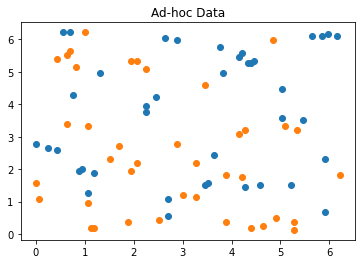

In [3]:
len_train = 40
len_test = 10
feature_dim = 2
sample_total, training_input, test_input, class_labels = ad_hoc_data(
    training_size=40,
    test_size=10,
    n=feature_dim,
    gap=0.2,
    plot_data=True
)


### Trainset

We need to design a preprocessing for the  training_input variable to the neccesary train sets: X_train, y_train

In [4]:
X_train = []
y_train = []
len_label = len(class_labels) 
index = 0 
for i in class_labels:
    y = [0.]*len_label
    train_set = training_input[i]
    X_train.extend(train_set)
    for i in range(len(train_set)):
        y[index] = 1.0
        y_train.append(y)
    index += 1
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

Print the result of the preprocessing

In [5]:
X_train, y_train

(array([[4.27256601, 1.44513262],
        [5.46637122, 3.51858377],
        [2.70176968, 1.0681415 ],
        [4.58672527, 1.50796447],
        [3.51858377, 1.57079633],
        [5.84336234, 6.09468975],
        [4.1469023 , 5.46637122],
        [5.2150438 , 1.50796447],
        [1.19380521, 1.88495559],
        [1.31946891, 4.96371639],
        [0.75398224, 4.27256601],
        [2.26194671, 3.76991118],
        [1.0681415 , 1.25663706],
        [5.90619419, 2.32477856],
        [0.87964594, 1.94778745],
        [5.02654825, 3.58141563],
        [2.70176968, 0.56548668],
        [5.96902604, 6.1575216 ],
        [3.64424748, 2.45044227],
        [2.89026524, 5.96902604],
        [5.90619419, 0.69115038],
        [0.9424778 , 2.0106193 ],
        [3.76991118, 5.78053048],
        [3.45575192, 1.50796447],
        [2.26194671, 3.95840674],
        [5.65486678, 6.09468975],
        [4.46106157, 5.34070751],
        [0.56548668, 6.22035345],
        [0.25132741, 2.63893783],
        [2.638

### Testset

We need to design a preprocessing for the  test_input variable to the neccesary train sets: X_test, y_test

In [6]:
X_test= []
y_test = []
index = 0 
for i in class_labels:
    y = [0.]*len_label
    test_set = test_input[i]
    X_test.extend(test_set)
    for i in range(len(test_set)):
        y[index] = 1.0
        y_test.append(y)
    index += 1

In [7]:
X_test, y_test

([array([2.70176968, 0.37699112]),
  array([3.83274304, 4.71238898]),
  array([3.70707933, 4.96371639]),
  array([2.51327412, 3.45575192]),
  array([5.59203492, 2.89026524]),
  array([0.31415927, 2.19911486]),
  array([1.25663706, 4.77522083]),
  array([4.83805269, 1.63362818]),
  array([4.64955713, 1.57079633]),
  array([1.19380521, 4.96371639]),
  array([1.38230077, 4.1469023 ]),
  array([6.22035345, 1.44513262]),
  array([4.20973416, 2.07345115]),
  array([1.94778745, 5.02654825]),
  array([4.77522083, 2.45044227]),
  array([4.77522083, 2.07345115]),
  array([5.15221195, 2.45044227]),
  array([6.03185789, 1.75929189]),
  array([6.22035345, 4.08407045]),
  array([4.58672527, 2.38761042])],
 [[1.0, 0.0],
  [1.0, 0.0],
  [1.0, 0.0],
  [1.0, 0.0],
  [1.0, 0.0],
  [1.0, 0.0],
  [1.0, 0.0],
  [1.0, 0.0],
  [1.0, 0.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0],
  [0.0, 1.0]])

### Design a method to plot the epoch

In [8]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

## QML part

Design the maping to the variables of each instance of the train dataset and design the ansatz.

### Mapping

Using the ZZFeatureMap method with the feature dimension with 2

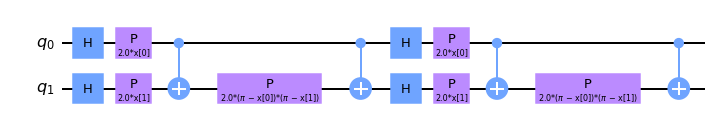

In [9]:
feature_map = ZZFeatureMap(feature_dim)
feature_map.decompose().draw("mpl")

### Ansatz

The variational Quantum circuit, in qiskit exist the possibility to apply pre-defined ansatz like RealAmplitudes

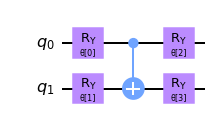

In [10]:
ansatz_c = RealAmplitudes(feature_dim, reps=1)
ansatz_c.decompose().draw("mpl")

This example we design own ansatz.

In [11]:
def ansatz(n, num_layers):
    #Set the number of layers and qubits
    #ParameterVectors are initialized with a string identifier and an integer specifying the vector length    
    parameters = ParameterVector('θ', n*(num_layers+1))

    circuit = QuantumCircuit(n,name='oracle')
    
    for i in range(n):
        circuit.h(i)
    
    for layer in range(num_layers):
        #Appending the parameterized Ry gates using parameters from the vector constructed above
        for i in range(n):
            circuit.ry(parameters[n*layer+i], i)

        #Appending the entangling CNOT gates
        for i in range(n-1):
            circuit.cx(i,1)

    #Appending one additional layer of parameterized Rz gates
        for i in range(n):
            circuit.rz(parameters[n*num_layers+i], i)
    
    for i in range(n):
        circuit.h(i)
    return circuit

In [12]:
num_layers = 2
ansatz_circuit = ansatz(feature_dim,num_layers)

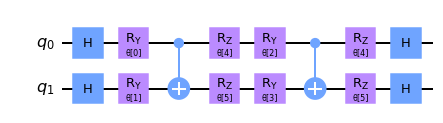

In [13]:
ansatz_circuit.draw("mpl")

## Simulation  part

The quantum instance for  simulation a quantum computing

In [14]:
quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=8192)

In [15]:

# construct variational quantum classifier
vqc = VQC(feature_map=feature_map,
          ansatz=ansatz_circuit,
          loss='cross_entropy',
          optimizer=COBYLA(),
          quantum_instance=quantum_instance,
          callback=callback_graph)


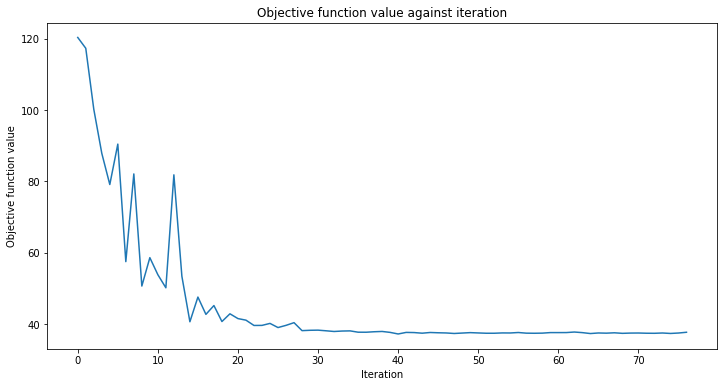

0.9375

In [16]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X_train, y_train)

In [17]:
vqc.score(X_test, y_test)

0.85

# General quantum circuit

For those kind of ways to simulate a quantum variational classifier we use the same quantum circuit

In [18]:
num_layers = 1
params = np.random.random([(1+num_layers)*feature_dim])  

In [19]:
def ansatz_m(n, num_layers,params):
    #Set the number of layers and qubits
    #ParameterVectors are initialized with a string identifier and an integer specifying the vector length    
    parameters = ParameterVector('θ', n*(num_layers+1))
    j = 0
    params_dict = {}
    circuit = QuantumCircuit(n)
    
    for i in range(n):
        circuit.h(i)
    
    for layer in range(num_layers):
        #Appending the parameterized Ry gates using parameters from the vector constructed above
        for i in range(n):
            circuit.ry(parameters[n*layer+i], i)

        #Appending the entangling CNOT gates
        for i in range(n-1):
            circuit.cx(i,1)

    #Appending one additional layer of parameterized Rz gates
        for i in range(n):
            circuit.rz(parameters[n*num_layers+i], i)
    
    for i in range(n):
        circuit.h(i)
    for p in parameters:
        params_dict[p] = params[j] 
        j += 1
    circuit = circuit.assign_parameters(parameters = params_dict)
    return circuit

In [20]:
import operator

def sim_variational_classifier(params):
    cost = 0
    acc = 0
    shots= 8192
    for i in range(len_train*2):
        qc = QuantumCircuit(feature_dim,feature_dim)
        qc.append(feature_map,range(feature_dim))
        j = 0
        inputs_dict = {}
        for index in feature_map.parameters:
            inputs_dict[index] = X_train[i][j] 
            j += 1
        qc = qc.assign_parameters(inputs_dict)
        qc.append(ansatz_m(feature_dim,num_layers,params),range(feature_dim))
        qc.measure(range(feature_dim),range(feature_dim))
        result = execute(qc, Aer.get_backend('qasm_simulator')).result()                 
        counts = result.get_counts(qc)
        y_pred = max(counts.items(), key=operator.itemgetter(1))[0]
        y_pred = [float(i) for i in y_pred]
        if y_pred[0] == y_train[i][0] and y_pred[1] == y_train[i][1]:
            acc += 1
        else:
            cost +=1
    return cost/(len_train*2)
num_parameters = 4
sim_variational_classifier(params)

0.7

In [21]:
print("cost")
print(sim_variational_classifier(params))

for i in range(10):
    optimizer = COBYLA(maxiter=20)
    ret = optimizer.optimize(num_vars=len(params),objective_function=sim_variational_classifier, initial_point=params)
    params = ret[0]
    print(ret[1])
    

cost
0.65
0.5625
0.4375
0.4125
0.4
0.4125
0.4
0.275
0.2375
0.25
0.2375
